The functions inside the `python_scripts/data` module are designed to download and manipulate datasets. Here is a brief description of each function:

1. `download_dataset(url, filename, folder)`: This function takes in the URL of a dataset, the desired filename for the downloaded file, and the folder name for the extracted dataset. It downloads the dataset from the specified *URL*, saves it with the given *filename*, and extracts it to the specified *folder*.

2. `make_data(folder)`: This function generates a dataframe by reading and processing the .DAT files inside the specified folder. It returns the dataframe containing the dataset. If the `dataset.pkl` file has already been generated, it just reads and save its content.

3. `plot_data(data, index)`: This function takes in a dataframe `data` and an index value. It plots the light curve for the SN associated to the specified index in the dataset.

In [1]:
# Import all useful functions to download and manipulate the dataset
from python_scripts.data import *
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# URL of the dataset
url = 'https://www.hep.anl.gov/SNchallenge/DES_BLIND+HOSTZ.tar.gz'
# Name of the downloaded file
filename = 'dataset.tar.gz'
# Name of the extracted folder
folder = 'DES_BLIND+HOSTZ'

There is no need to execute the `download_dataset()` function if the `dataset.pkl` file has already been generated, so if you do not wish to look at the original data simply do not execute (comment) the cell below.

In [2]:
# Download and extract the dataset 
download_dataset(url, filename, folder)

Dataset already downloaded.
Dataset already extracted.


In [3]:
# Generate the dataframe for all the .DAT files inside the DES_BLIND folder
data = make_data(folder)

Dataset already generated.


### __1. Dataset Preparation__
Unfortunately, we only have $1250$ labelled supernova events available, compared to over $17000$ data for which the type of event is not provided. The aim is to combine the application of supervised learning and unsupervised learning techniques to obtain a classifier with satisfactory accuracy.

In [4]:
# Count the number of data points with SNTYPE == '-9' and all the other possibilities
label_counts = data['SNTYPE'].value_counts()
label_table = pd.DataFrame({'Label': label_counts.index, 'Count': label_counts.values})
label_table['Percentage'] = (label_table['Count'] / label_table['Count'].sum() * 100).round(2)
label_table['SN Type'] = ['Unknown', 'Type Ia', 'Type IIn', 'Type IIp', 'Type IIL', 'Type Ibc', 'Type Ib', 'Type Ic']
label_table


,Label,Count,Percentage,SN Type
0,-9,17052,93.17,Unknown
1,1,879,4.80,Type Ia
2,22,216,1.18,Type IIn
3,32,55,0.30,Type IIp
4,21,44,0.24,Type IIL
5,33,42,0.23,Type Ibc
6,3,12,0.07,Type Ib
7,23,2,0.01,Type Ic


By looking at the `make_data()` function, I'd like to highlight two aspects regarding the final adjustments to the dataframe:

1. For now, we simply clean the dataset by removing `nan` values. Replacing these values using some common strategies (*fixed*, *average* or *fitted* values) could be a source of error, as each SNS is identified precisely by the feature set.

2. As you can see from the original `.DAT` files, the observation time is given in Modified Julian Days (MJD). Although the unit of measurement is not a problem from the perspective of the classification algorithm, it is good to convert these values into **number of days since first observation** to visualise the light curves.

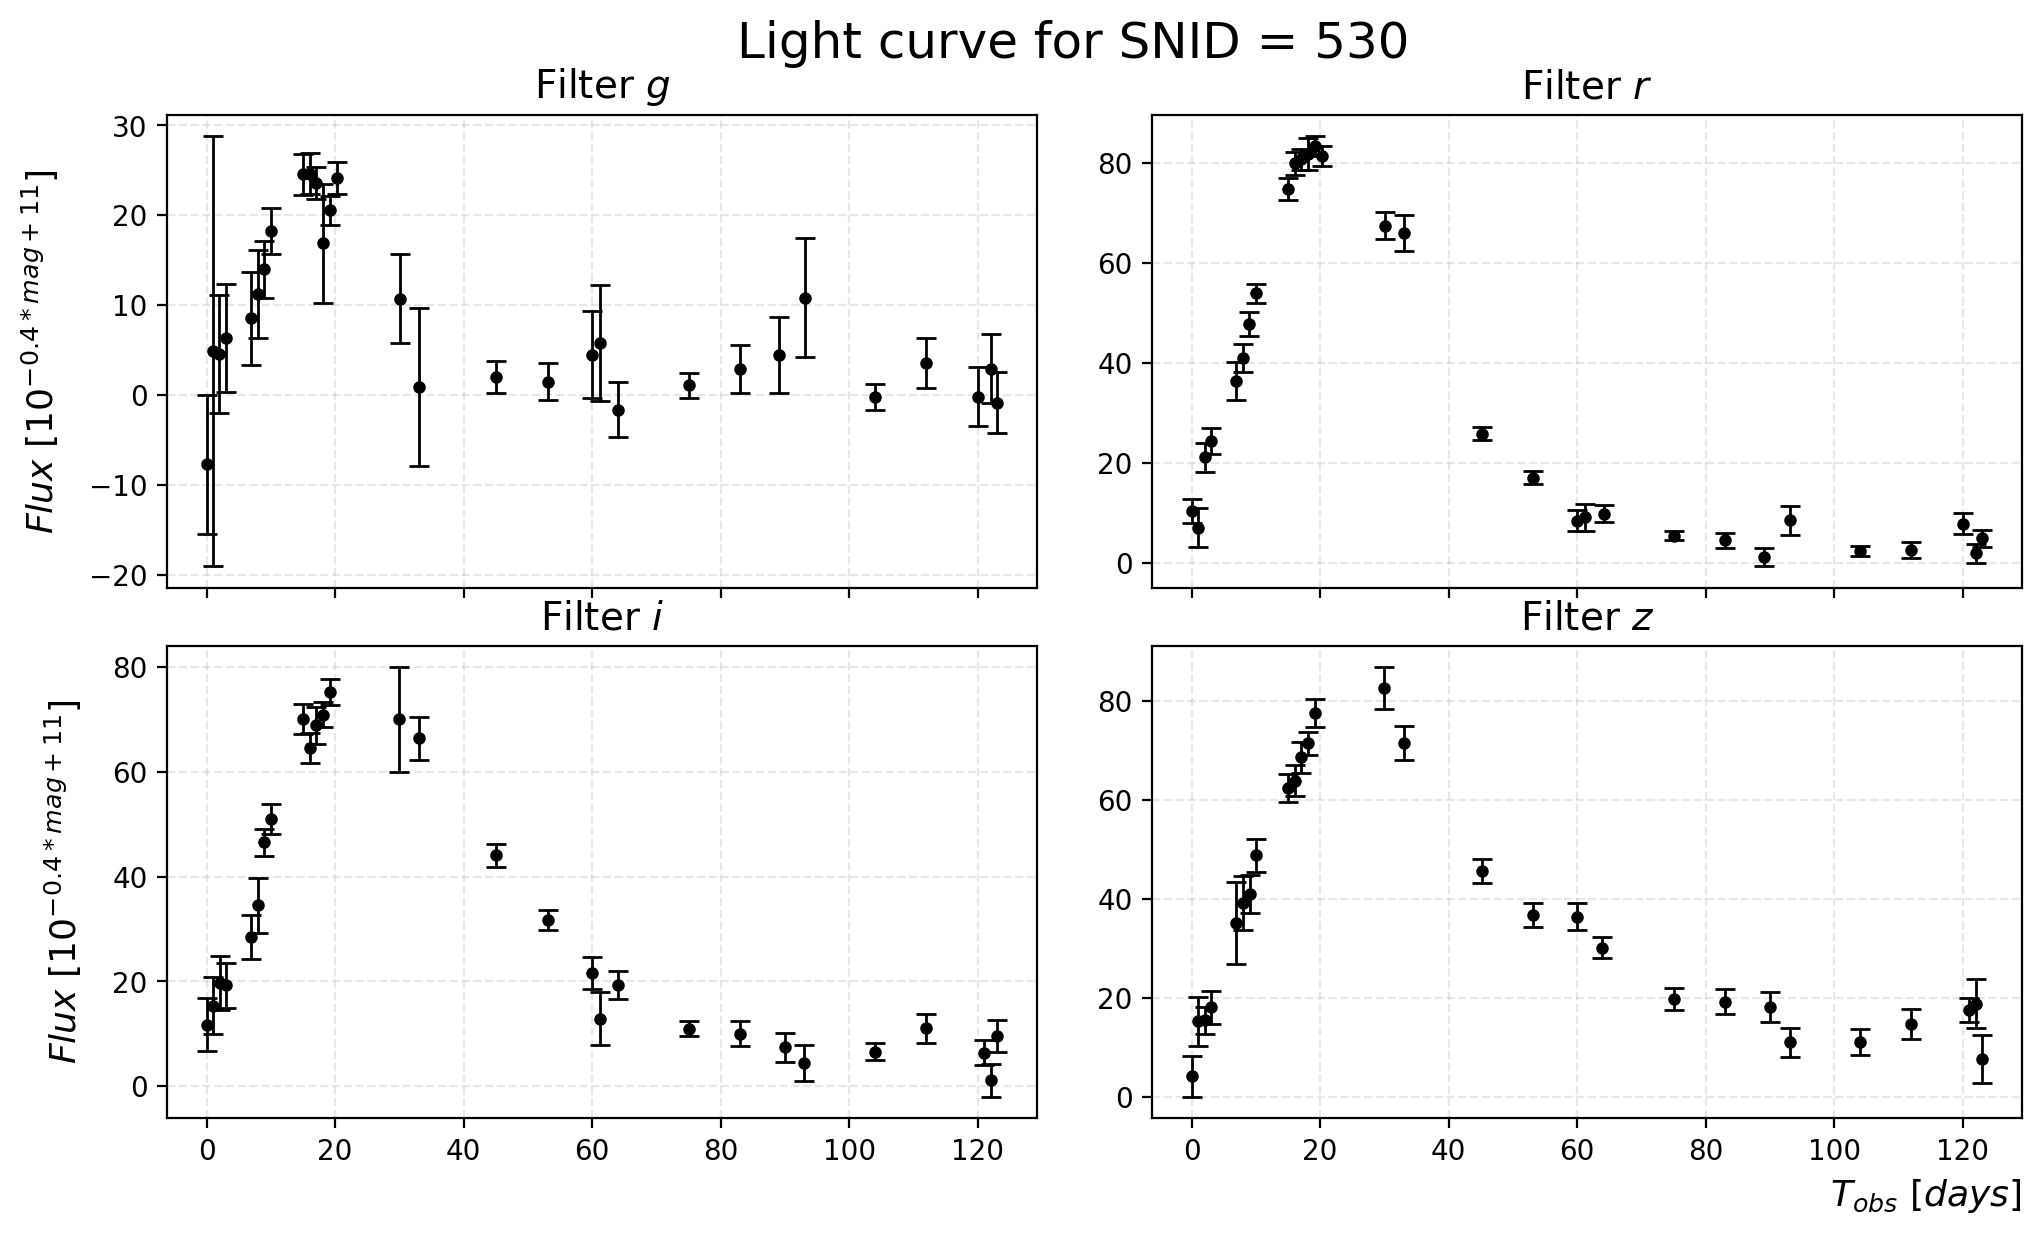

In [5]:
# Plot the SN530 Light Curve
plot_data(data, SNID=530)

In [6]:
# Define the training data as the data points with known SNTYPE
train_data = data[data['SNTYPE'] != '-9']

Note that this training set is not representative in brightness, therefore in *redshift* ($z$). This was done to emulate the way spectroscopic measures are currently performed, prioritizing low-redshift, bright objects.

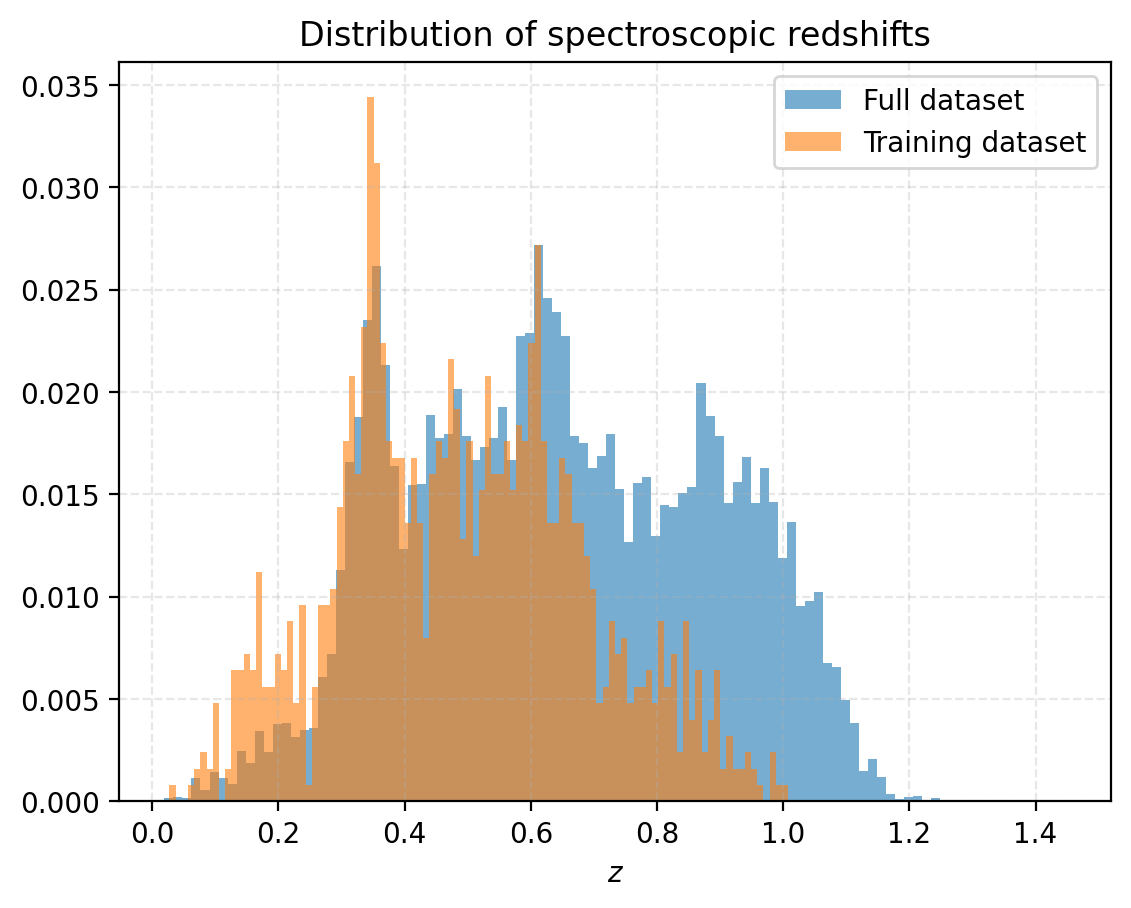

In [7]:
# Look at the distribution of the spectroscopic redshifts for both the full dataset and the training dataset
for df, label in zip([data['HOST_GALAXY_PHOTO-Z'], train_data['HOST_GALAXY_PHOTO-Z']], ['Full dataset', 'Training dataset']):
    plt.hist(df, bins=100, alpha=0.6, label=label,
            weights=np.zeros_like(df) + 1. / df.size);
plt.legend()
plt.grid(True, alpha=0.3, linestyle='--')
plt.title('Distribution of spectroscopic redshifts')
plt.xlabel('$z$')
plt.show()

### __2. Feature Extraction__
As can be seen, the light curves are characterised by multiple points per filter, resulting in a very large number $ \left(\gtrsim 100 \right)$ of possible features for a classification algorithm. A first step of dimensionality reduction is therefore necessary: __feature extraction__.\
In particular, a $6$-parameter function is used to parameterise each curve, resulting in $24$ parameters for each SN:

$$f(t) = A \left[ 1 + B(t - t_1)^2 \right] \cdot \left( \frac{e^{-(t - t_0) / T_f}}{1 + e^{-(t - t_0) / T_r}} \right)$$

Such a function is taken from [Karpenka et al., 2013](https://academic.oup.com/mnras/article/429/2/1278/1038192). Although the function has no clear physical meaning, it is sufficiently general to fit the shape of almost any SN light curve, including the possibility of it having two peaks. Furthermore, no offset parameter is included since, by construction of the simulations, the light curves have zero flux well outside the event region. 

Here's a breakdown of the parameters and their effects:

1. $A$: *Amplitude*, determines the maximum value that the function can reach. It controls the overall height or scale of the function.

2. $B$: *Curvature*, influences the curvature or shape of the function. A higher value of $B$ makes the function more peaked or curved, while a lower value makes it flatter.

3. $t_1$: *Time shift for the quadratic term*$^1$, represents a shift along the time axis for the quadratic term $(t - t_1)^2$. It influences where the peak of the quadratic term occurs in time.

4. $t_0$: *Time shift for the exponential term*$^1$, represents a shift along the time axis for the exponential term $e^{-(t - t_0) / T_f}$. It influences the position of the exponential decay in time.

5. $T_f$: *Time constant for the exponential decay*, controls the rate of decay of the exponential term. A smaller value makes the decay happen more quickly, while a larger value makes it decay more slowly.

6. $T_r$: Time constant for the sigmoid term, controls the transition width of the sigmoid function in the denominator. A smaller value leads to a sharper transition, while a larger one results in a smoother transition.

<font size=2>

$1$: Notice that both $t_0$ and $t_1$ play a role in the position of the light curve __maximum__. 

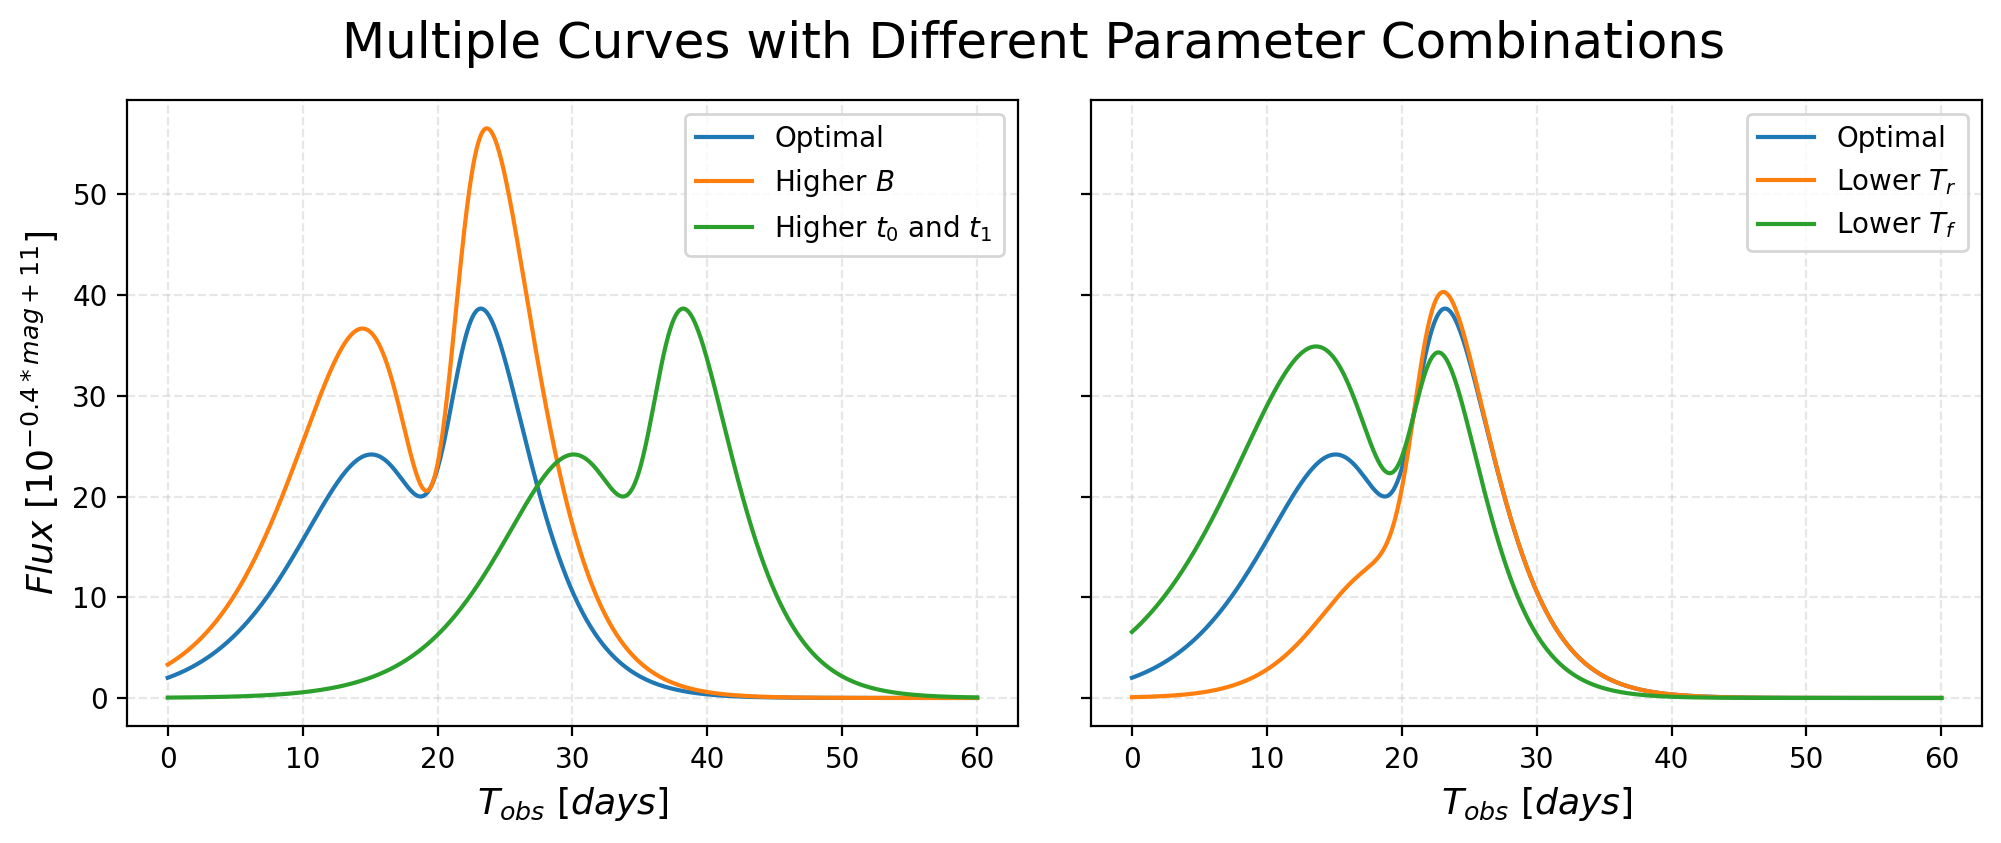

In [8]:
# From utils.py we can import the function to plot the function using various parameter combinations
from python_scripts.utils import plotFunc

plotFunc()

Dataset already generated.


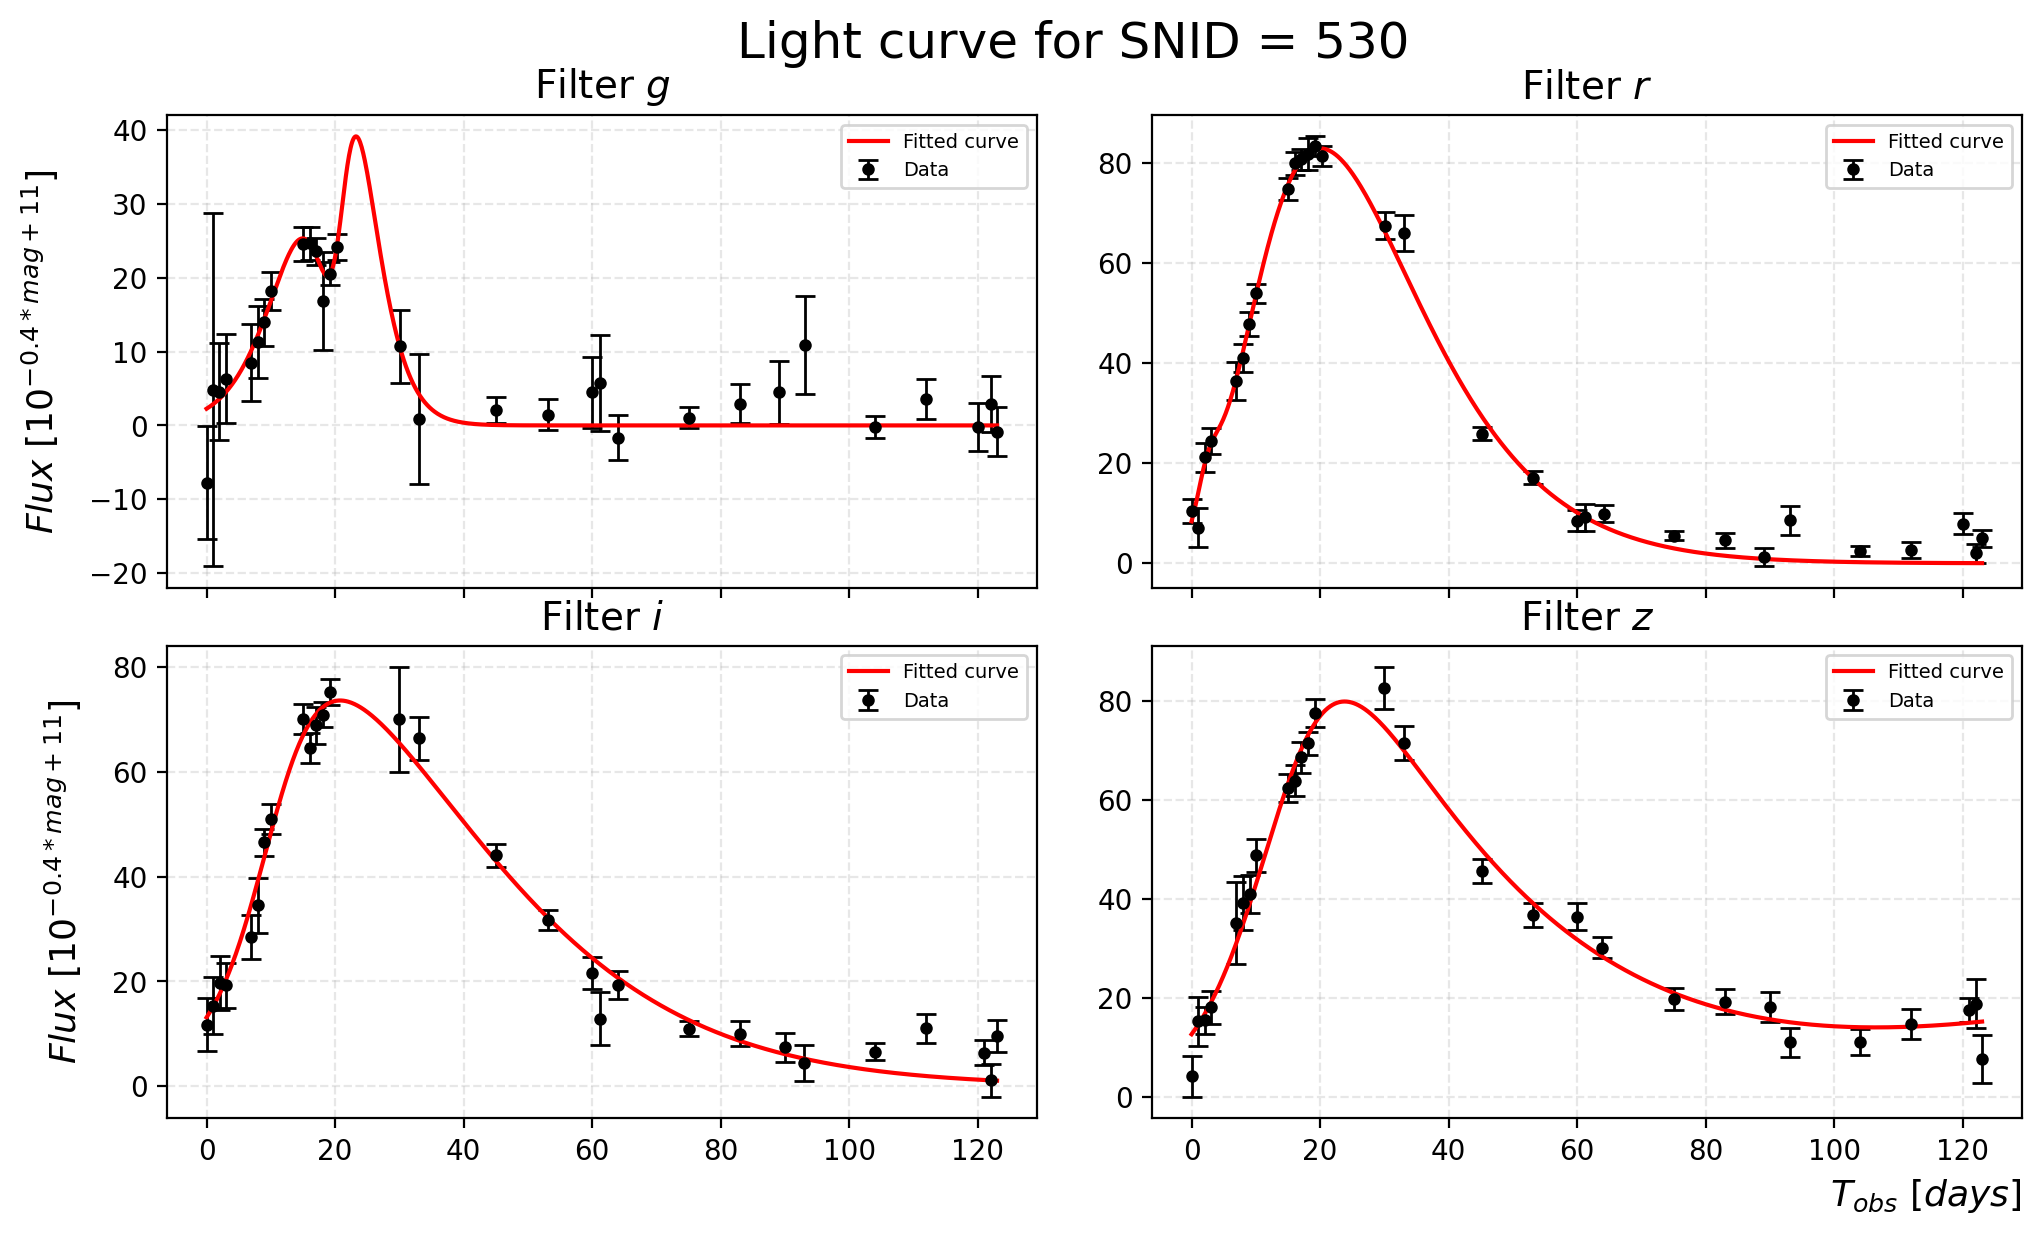

In [10]:
# Instantiate the class to get the parameters of the training data
inst = getParams(train_data)
# Fit the data to get the light curve parameters
train_data = inst.fitData()
# As you can see, the model takes into account double peaks
plot_light_curves(train_data, inst.par_cols, SNID=train_data.iloc[3]['SNID'])